<a href="https://colab.research.google.com/github/yukinaga/minnano_ai/blob/master/section_5/train_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 出力層の学習
出力層のパラメータを更新する仕組みをニューラルネットワークに導入し、実際にパラメータが更新されることを確認します。

## ● ニューラルネットワークの復習
前回構築したニューラルネットワークを復習します。  
以下のコードで実装されるニューラルネットワークは、中間層に2つ、出力層に2つのニューロンを持ちます。  
SetosaとVersicolorにIrisの品種を分類しますが、パラメータが調整されていないため、まだ適切に品種を分類することができません。

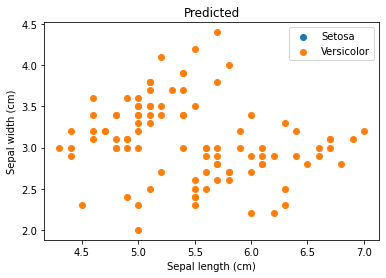

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
iris_data = iris.data
sl_data = iris_data[:100, 0] # SetosaとVersicolor、Sepal length
sw_data = iris_data[:100, 1] # SetosaとVersicolor、Sepal width

# 平均値を0に
sl_ave = np.average(sl_data)  # 平均値
sl_data -= sl_ave  # 平均値を引く
sw_ave = np.average(sw_data)
sw_data -= sw_ave

# 入力をリストに格納
input_data = []
for i in range(100):  # iには0から99までが入る
    input_data.append([sl_data[i], sw_data[i]])

# シグモイド関数
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# ニューロン
class Neuron:
    def __init__(self):  # 初期設定
        self.input_sum = 0.0
        self.output = 0.0

    def set_input(self, inp):
        self.input_sum += inp

    def get_output(self):
        self.output = sigmoid(self.input_sum)
        return self.output

    def reset(self):
        self.input_sum = 0
        self.output = 0

# ニューラルネットワーク
class NeuralNetwork:
    def __init__(self):  # 初期設定
        # 重み
        self.w_im = [[4.0, 4.0], [4.0, 4.0]]  # 入力:2 ニューロン数:2
        self.w_mo = [[1.531288543605751, -0.6352400552991943]]  # 入力:2 ニューロン数:1

        # バイアス
        self.b_m = [2.0, -2.0]  # ニューロン数:2
        self.b_o = [0.09558734488370531]  # ニューロン数:1

        # 各層の宣言
        self.input_layer = [0.0, 0.0]
        self.middle_layer = [Neuron(), Neuron()]
        self.output_layer = [Neuron()]

    def commit(self, input_data):  # 実行
        # 各層のリセット
        self.input_layer[0] = input_data[0]  # 入力層は値を受け取るのみ
        self.input_layer[1] = input_data[1]
        self.middle_layer[0].reset()
        self.middle_layer[1].reset()
        self.output_layer[0].reset()

        # 入力層→中間層
        self.middle_layer[0].set_input(self.input_layer[0] * self.w_im[0][0])
        self.middle_layer[0].set_input(self.input_layer[1] * self.w_im[0][1])
        self.middle_layer[0].set_input(self.b_m[0])

        self.middle_layer[1].set_input(self.input_layer[0] * self.w_im[1][0])
        self.middle_layer[1].set_input(self.input_layer[1] * self.w_im[1][1])
        self.middle_layer[1].set_input(self.b_m[1])

        # 中間層→出力層
        self.output_layer[0].set_input(self.middle_layer[0].get_output() * self.w_mo[0][0])
        self.output_layer[0].set_input(self.middle_layer[1].get_output() * self.w_mo[0][1])
        self.output_layer[0].set_input(self.b_o[0])

        return self.output_layer[0].get_output()

# ニューラルネットワークのインスタンス
neural_network = NeuralNetwork()

# 実行
st_predicted = [[], []]  # Setosa
vc_predicted = [[], []]  # Versicolor
for data in input_data:
    if neural_network.commit(data) < 0.5:
        st_predicted[0].append(data[0]+sl_ave)
        st_predicted[1].append(data[1]+sw_ave)
    else:
        vc_predicted[0].append(data[0]+sl_ave)
        vc_predicted[1].append(data[1]+sw_ave)

# 分類結果をグラフ表示
plt.scatter(st_predicted[0], st_predicted[1], label="Setosa")
plt.scatter(vc_predicted[0], vc_predicted[1], label="Versicolor")
plt.legend()

plt.xlabel("Sepal length (cm)")
plt.ylabel("Sepal width (cm)")
plt.title("Predicted")
plt.show()

## ● 出力層のパラメータを更新
出力層の重みとバイアスを更新します。  

最初に、修正量のベース$\delta_o$を求めます。   
**$\delta_o$ = (出力 - 正解) × 活性化関数の微分形**  
  
活性化関数がシグモイド関数の場合、上記は以下の形になります。  
**$\delta_o$ = (出力 - 正解) × 出力 × (1 - 出力)**  
  
そして、この$\delta_o$を使って出力層における重みとバイアスの修正量を求めます。  
**重みの修正量 = - 学習係数 × $\delta_o$ × 入力**  
**バイアスの修正量 = - 学習係数 × $\delta_o$**  
以下のコードは、これらのこれらの式を使って出力層の各パラメータを1回だけ更新します。  

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import random

iris = datasets.load_iris()
iris_data = iris.data
sl_data = iris_data[:100, 0] # SetosaとVersicolor、Sepal length
sw_data = iris_data[:100, 1] # SetosaとVersicolor、Sepal width

# 平均値を0に
sl_ave = np.average(sl_data)  # 平均値
sl_data -= sl_ave  # 平均値を引く
sw_ave = np.average(sw_data)
sw_data -= sw_ave

# 入力をリストに格納
train_data = []
for i in range(100):  # iには0から99までが入る
    correct = iris.target[i]
    train_data.append([sl_data[i], sw_data[i], correct])
print(train_data)

# シグモイド関数
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# ニューロン
class Neuron:
    def __init__(self):  # 初期設定
        self.input_sum = 0.0
        self.output = 0.0

    def set_input(self, inp):
        self.input_sum += inp

    def get_output(self):
        self.output = sigmoid(self.input_sum)
        return self.output

    def reset(self):
        self.input_sum = 0
        self.output = 0

# ニューラルネットワーク
class NeuralNetwork:
    def __init__(self):  # 初期設定
        # 重み
        self.w_im = [[4.0, 4.0], [4.0, 4.0]]  # 入力:2 ニューロン数:2
        self.w_mo = [[1.0, -1.0]]  # 入力:2 ニューロン数:1

        # バイアス
        self.b_m = [2.0, -2.0]  # ニューロン数:2
        self.b_o = [-0.5]  # ニューロン数:1

        # 各層の宣言
        self.input_layer = [0.0, 0.0]
        self.middle_layer = [Neuron(), Neuron()]
        self.output_layer = [Neuron()]

    def commit(self, input_data):  # 実行
        # 各層のリセット
        self.input_layer[0] = input_data[0]  # 入力層は値を受け取るのみ
        self.input_layer[1] = input_data[1]
        self.middle_layer[0].reset()
        self.middle_layer[1].reset()
        self.output_layer[0].reset()

        # 入力層→中間層
        self.middle_layer[0].set_input(self.input_layer[0] * self.w_im[0][0])
        self.middle_layer[0].set_input(self.input_layer[1] * self.w_im[0][1])
        self.middle_layer[0].set_input(self.b_m[0])

        self.middle_layer[1].set_input(self.input_layer[0] * self.w_im[1][0])
        self.middle_layer[1].set_input(self.input_layer[1] * self.w_im[1][1])
        self.middle_layer[1].set_input(self.b_m[1])

        # 中間層→出力層
        self.output_layer[0].set_input(self.middle_layer[0].get_output() * self.w_mo[0][0])
        self.output_layer[0].set_input(self.middle_layer[1].get_output() * self.w_mo[0][1])
        self.output_layer[0].set_input(self.b_o[0])

        return self.output_layer[0].get_output()

    def train(self, correct):
        # 学習係数
        k = 0.3

        #  出力
        output_o = self.output_layer[0].output
        output_m0 = self.middle_layer[0].output
        output_m1 = self.middle_layer[1].output

        # δ
        delta_o = (output_o - correct) * output_o * (1.0 - output_o)

        # パラメータの更新
        self.w_mo[0][0] -= k * delta_o * output_m0
        self.w_mo[0][1] -= k * delta_o * output_m1
        self.b_o[0] -= k * delta_o


# ニューラルネットワークのインスタンス
neural_network = NeuralNetwork()

# 学習によるパラメータの変化
print("-------- Before train --------")
print(neural_network.w_im)
print(neural_network.w_mo)
print(neural_network.b_m)
print(neural_network.b_o)
for i in range(100):
    neural_network.commit(train_data[i][:2])  # 順伝播
    neural_network.train(train_data[i][2])  # 逆伝播
    print("-------- After train ({})--------".format(i))
    print(neural_network.w_im)
    print(neural_network.w_mo)
    print(neural_network.b_m)
    print(neural_network.b_o)

[[-0.37100000000000133, 0.40100000000000025, 0], [-0.5710000000000006, -0.09899999999999975, 0], [-0.7710000000000008, 0.10100000000000042, 0], [-0.8710000000000013, 0.001000000000000334, 0], [-0.471000000000001, 0.5010000000000003, 0], [-0.07100000000000062, 0.8010000000000002, 0], [-0.8710000000000013, 0.30100000000000016, 0], [-0.471000000000001, 0.30100000000000016, 0], [-1.0710000000000006, -0.19899999999999984, 0], [-0.5710000000000006, 0.001000000000000334, 0], [-0.07100000000000062, 0.6010000000000004, 0], [-0.6710000000000012, 0.30100000000000016, 0], [-0.6710000000000012, -0.09899999999999975, 0], [-1.1710000000000012, -0.09899999999999975, 0], [0.32899999999999885, 0.9010000000000002, 0], [0.2289999999999992, 1.3010000000000006, 0], [-0.07100000000000062, 0.8010000000000002, 0], [-0.37100000000000133, 0.40100000000000025, 0], [0.2289999999999992, 0.7010000000000001, 0], [-0.37100000000000133, 0.7010000000000001, 0], [-0.07100000000000062, 0.30100000000000016, 0], [-0.3710000

In [5]:
# コード練習用
print(range(0, 100))

range(0, 100)
